# Scaling the 2d Acoustic Wave Equation

## Unscaled version

2d Acoustic Wave Equation: $\frac{\partial^2 p}{\partial t^2} = c^2 \nabla^2 p + s(x, z, t)$

Where $ p \equiv p(x, z, t) $ and $ s(x, z, t) $ is a source term

In [24]:
# import dependencies 
import devito as dv
import numpy as np
from examples.seismic.source import TimeAxis
from examples.seismic import RickerSource

# Initial grid: 2km x 2km, with spacing 100m
extent = (2000., 2000.)
shape = (200, 200)
x = dv.SpaceDimension(name='x', spacing=dv.Constant(name='h_x', value=extent[0]/(shape[0]-1)))
z = dv.SpaceDimension(name='z', spacing=dv.Constant(name='h_z', value=extent[1]/(shape[1]-1)))
grid = dv.Grid(extent=extent, shape=shape, dimensions=(x, z))

# calculating timestep with CFL condition, max V_p=6000, and dx=100
# played around with tn to get different output images - wave hits the edge of the grid around tn=400
t0, tn = 0., 250.
dt = 1e2*(1. / np.sqrt(2.)) / 60.
time_range = TimeAxis(start=t0, stop=tn, step=dt)

# creating source term, f=0.03 kHz (30Hz)
src = RickerSource(name='src', grid=grid, f0=0.03, npoint=1, time_range=time_range)
# setting source to the middle of the grid
src.coordinates.data[:] = [1000., 1000.]

# creating pressure field
p = dv.TimeFunction(name='p', grid=grid, space_order=2, time_order=2)

# setting up velocity field with a layered model
constant_vp = 3
vp = dv.Function(name='vp', grid=grid)
vp.data[:, :100] = 2.5  # layer 1: 2.5km/s
vp.data[:, 100:] = 3.5  # layer 2: 3.5km/s

# injecting the source term to the pressure field, edit expr to vary source term
src_p = src.inject(field=p.forward, expr=src)

# defining pde and creating stencil
pde = p.dt2 - constant_vp**2*p.laplace
stencil = dv.Eq(p.forward, dv.solve(pde, p.forward))

# set up operator
op = dv.Operator([stencil] + src_p)

# call operator to propagate source
op(time=src.time_range.num-1, dt=dt)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.0034009999999999926, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=4e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

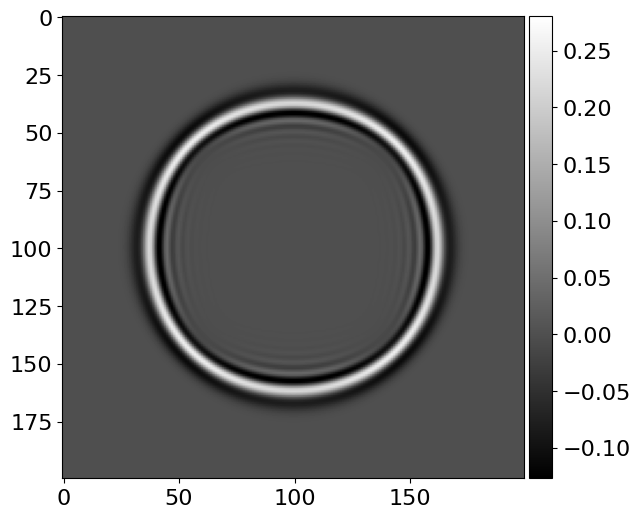

In [25]:
# visualise output
from examples.seismic import plot_image

plot_image(p.data[0])

## Scaled version

Transformed 2d acoustic wave equation: $\frac{\partial^2 p'}{\partial t^2} = c^2 \nabla^2 p' + \frac{s(x, z, t)}{\alpha}$

Where $ p'(x, z, t) \equiv \frac{p(x, z, t)}{\alpha} $ with $ \alpha = p_{max} $

In [26]:
# using same grid, time range, source set up and velocity as above

# redefine pressure field, pde and stencil, source term injection, set up new operator

# scaled pressure field
p_scaled = dv.TimeFunction(name='ps', grid=grid, space_order=2, time_order=2)

# defining scaling factors
# maximum pressure of simulation is 1 (corresponds with source term)
# using alpha = 1 has no effect - selected 1.2 for testing purposes
alpha = 1.2

# redefining pde and stencil
pde_transform = p_scaled.dt2 - constant_vp**2*p_scaled.laplace
stencil_transform = dv.Eq(p_scaled.forward, dv.solve(pde_transform, p_scaled.forward))

# redefining source term injection
src_scaled = src.inject(field=p_scaled.forward, expr=src/alpha)

# new operator
op_scaled = dv.Operator([stencil_transform] + src_scaled)

# calling operator
op_scaled(time=src.time_range.num-1, dt=dt)

# rescaling output
p_scaled.data[:] *= alpha

Operator `Kernel` ran in 0.01 s


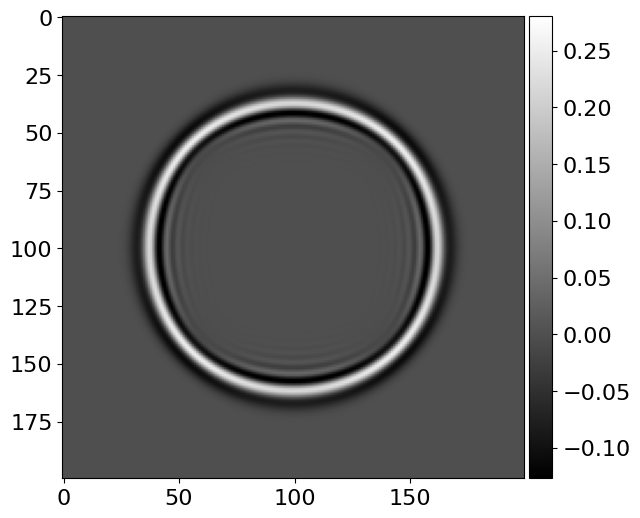

In [27]:
# showing output
plot_image(p_scaled.data[0])

In [36]:
# compare the output of the two simulations 
# relative/absolute tolerances = 3/4 as rounding from single to half precision loses 3/4 decimal places (from 7 to 3.5)
close_check = np.isclose(p.data, p_scaled.data, rtol=1e-3, atol=1e-4)

# check if all values are close
all_close = np.all(close_check)
all_close

Data(True)